## Fine-Tuning deepset/gbert-base for German Hate Speech Classification
This notebook fine-tunes `deepset/gbert-base` on a German hate speech dataset using PyTorch, BERT and CNN Layer.

For the hyperparameter tuning optuna and the Tree-structured Parzen estimator (TPE), a Bayesian optimization method is used. For stopping unpromising trials early the MedianPruner is used.

The script automatically logs the model metrics to the wandb project as well as to "logged_model_metrics.xlsx"


Inspiration for this setup: <br>

Cendra Devayana Putra, Hei-Chia Wang,
Advanced BERT-CNN for Hate Speech Detection,
Procedia Computer Science,
Volume 234,
2024,
Pages 239-246,
ISSN 1877-0509,
https://doi.org/10.1016/j.procs.2024.02.170.

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.1 MB/s eta 0:00:00


In [ ]:
# Import Libraries
import wandb
import optuna
from optuna.pruners import MedianPruner
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    balanced_accuracy_score
    , accuracy_score
    , precision_recall_fscore_support
    , matthews_corrcoef
    , classification_report
    , f1_score
    , log_loss
    , precision_score
    , recall_score
    , fbeta_score
    , confusion_matrix
    , ConfusionMatrixDisplay
)
from transformers import AutoTokenizer, BertModel, Trainer, TrainingArguments
import logging
import os
from google.colab import runtime, userdata, drive
import datetime
import threading
import time

## Set up logging and connections

In [ ]:
# Configure Logging
logging.basicConfig(
    level=logging.INFO,  # Log INFO
    format="%(asctime)s - %(levelname)s - %(message)s",
    force=True
)

logger = logging.getLogger(__name__)

# empty cache
torch.cuda.empty_cache()

In [ ]:
# connect to wandb
wandbkey = userdata.get('WandbKey')
wandb.login(key=wandbkey)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: maxnienh (maxnienh-xx). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Set Device to GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
logger.info(f"Using device: {device}")
if torch.cuda.is_available():
    logger.info(f"GPU Name: {torch.cuda.get_device_name(0)}")


2025-01-04 23:29:04,863 - INFO - Using device: cuda
2025-01-04 23:29:04,887 - INFO - GPU Name: NVIDIA A100-SXM4-40GB


In [ ]:
# mount google drive for folder access
drive.mount('/content/drive')

Mounted at /content/drive


## Define BERT model class

In [ ]:
class BERT_CNN(nn.Module):
    def __init__(self, bert_model_name, num_labels, dropout_rate=0.3, class_weights=None):
        """
        Initializes a BERT-based model with a CNN layer for text classification.

        :param bert_model_name: Name of the pre-trained BERT model to be used.
        :param num_labels: Number of output classes for classification.
        :param dropout_rate: Dropout rate for regularization.
        :param class_weights: Optional tensor containing class weights for handling class imbalance.
        """
        
        super(BERT_CNN, self).__init__()

        # Load pre-trained BERT model
        self.bert = BertModel.from_pretrained(bert_model_name)

        # Dropout for regularization
        self.dropout_bert = nn.Dropout(dropout_rate)
        self.dropout_cnn = nn.Dropout(dropout_rate)

        # CNN-Layer
        self.conv1d = nn.Conv1d(
            in_channels=self.bert.config.hidden_size,  # Hidden size from BERT
            out_channels=128,  # Number of output channels
            kernel_size=3,  # Filter size
            padding=1
        )
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2)

        # Fully Connected Classification Layer
        self.classifier = nn.Linear(128, num_labels)

        self.class_weights = class_weights

    def forward(self, input_ids, attention_mask, labels=None):
        """
        Forward pass through the model.

        :param input_ids: Tensor of tokenized input IDs.
        :param attention_mask: Tensor indicating which tokens should be attended to.
        :param labels: Optional tensor of target labels for loss calculation.
        :return: Loss (if labels are provided) and logits.
        """
        
        # Extract features from BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)

        # Dropout after BERT output
        sequence_output = self.dropout_bert(sequence_output)

        # Pass through CNN
        cnn_output = self.conv1d(sequence_output.permute(0, 2, 1))  # Conv1d expects (batch, channels, seq_len)
        cnn_output = self.relu(cnn_output)
        cnn_output = self.maxpool(cnn_output)

        # Average pooling across the sequence length
        pooled_output = torch.mean(cnn_output, dim=2)  # Shape: (batch_size, channels)

        # Dropout after CNN output
        pooled_output = self.dropout_cnn(pooled_output)

        # Pass through the classifier
        logits = self.classifier(pooled_output)

        # Compute loss if labels are provided
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(weight=class_weights) # for balancing the classes
            loss = loss_fct(logits.view(-1, self.classifier.out_features), labels.view(-1))
            return loss, logits

        return logits

## Load, split and tokenize data

In [ ]:
#import pandas as pd
dataset_filename = "Dataset_anonymized_annotated_comments_same_annotation_final.csv"
csv_path = os.path.join('/content/drive/MyDrive/model/data', dataset_filename)

# Load the dataset
data = pd.read_csv(csv_path, delimiter=';', on_bad_lines='skip')
data = data[['comment', 'annotation']]
logger.info(f"Dataset loaded with shape: {data.shape}")

# Compute Class Weights using the normalized formula
class_counts = data['annotation'].value_counts().sort_index()
total_samples = class_counts.sum()
num_classes = len(class_counts)

# Improved inverse class weights
class_weights = total_samples / (num_classes * class_counts)
class_weights = torch.tensor(class_weights.values, dtype=torch.float32).to(device)
logger.info(f"Computed class weights: {class_weights}")

2025-01-04 23:29:48,550 - INFO - Dataset loaded with shape: (23580, 2)
2025-01-04 23:29:49,128 - INFO - Computed class weights: tensor([0.7221, 1.6258], device='cuda:0')


In [ ]:
# Variable to switch between full and small dataset (for tests)
use_full_dataset = 1

# Split into training (70%), validation (15%), and test (15%) datasets
if use_full_dataset == 1:

  train_data, temp_data = train_test_split(data, test_size=0.3, stratify=data['annotation'], random_state=42)
  val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['annotation'], random_state=42)
  logger.info(f"Train size: {len(train_data)} rows | Test size: {len(test_data)} rows | Validation size: {len(val_data)} rows")

else:
  #Separate Dataset into two groups
  hate_data = data[data['annotation'] == 1]
  no_hate_data = data[data['annotation'] == 0]

  #Take n random comments out of both groups to create a balanced dataset
  subset_size_per_class = 500
  positive_subset = hate_data.sample(n=subset_size_per_class, random_state=42)
  negative_subset = no_hate_data.sample(n=subset_size_per_class, random_state=42)

  # Combine both groups into one dataset
  balanced_subset = pd.concat([positive_subset, negative_subset])

  # Shuffle and reset index
  balanced_subset = balanced_subset.sample(frac=1, random_state=42).reset_index(drop=True)

  # Verify balance
  logger.info(f"Balanced subset size: {len(balanced_subset)} rows")
  logger.info(f"Annotation distribution: {balanced_subset['annotation'].value_counts()}")

  train_size = int(0.7 * len(balanced_subset))
  val_size = int(0.15 * len(balanced_subset))

  train_data = balanced_subset[:train_size]
  val_data = balanced_subset[train_size:train_size + val_size]
  test_data = balanced_subset[train_size + val_size:]

  # Log sizes of each split
  logger.info(f"Small Train size: {len(train_data)} rows | Small Test size: {len(test_data)} rows | Small Validation size: {len(val_data)} rows")

2025-01-04 23:29:49,146 - INFO - Balanced subset size: 1000 rows
2025-01-04 23:29:49,148 - INFO - Annotation distribution: annotation
0    500
1    500
Name: count, dtype: int64
2025-01-04 23:29:49,149 - INFO - Small Train size: 700 rows | Small Test size: 150 rows | Small Validation size: 150 rows


In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('deepset/gbert-base')

# Define tokenization function
def tokenize_texts(texts, tokenizer, max_length=256): # reduced from the standard 512 to 256
    """
    Tokenizes a list of input texts.

    :param texts: List of input text strings.
    :param tokenizer: Tokenizer to be used (e.g., BERT tokenizer).
    :param max_length: Maximum sequence length for tokenization.
    :return: Dictionary of tokenized outputs, including input IDs and attention masks.
    """
    
    return tokenizer(
        list(texts),
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt"
    )

# Tokenize train and test datasets
train_encodings = tokenize_texts(train_data['comment'], tokenizer)
val_encodings = tokenize_texts(val_data['comment'], tokenizer)
test_encodings = tokenize_texts(test_data['comment'], tokenizer)

# Define Dataset class
class HateSpeechDataset(Dataset):
    def __init__(self, encodings, labels):
        """
        Custom dataset class for handling tokenized text and labels.

        :param encodings: Tokenized text data.
        :param labels: Corresponding labels for classification.
        """
        
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Retrieves a sample from the dataset.

        :param idx: Index of the sample to retrieve.
        :return: Dictionary containing tokenized inputs and label.
        """
        
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        :return: Integer count of samples.
        """
        
        return len(self.labels)

# Create datasets
train_dataset = HateSpeechDataset(train_encodings, train_data['annotation'].values)
val_dataset = HateSpeechDataset(val_encodings, val_data['annotation'].values)
test_dataset = HateSpeechDataset(test_encodings, test_data['annotation'].values)

# Show length of training samples
logger.info(f"Training samples: {len(train_dataset)} | Test samples: {len(test_dataset)} | Validation samples: {len(val_dataset)}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/83.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/362 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

2025-01-04 23:29:51,003 - INFO - Training samples: 700 | Test samples: 150 | Validation samples: 150


## Define the function for calculating metrics and training

In [ ]:
def compute_metrics(eval_pred, trial=None, trainer=None):
    """
    Computes evaluation metrics for classification.

    :param eval_pred: Tuple containing predictions and labels.
    :param trial: Optional Optuna trial object for hyperparameter tuning.
    :param trainer: Optional Trainer object for tracking progress.
    :return: Dictionary containing accuracy, precision, recall, F1-score, F2-score, and other metrics.
    """
    
    # metrics computation for model evaluation, WandB tracking, and Optuna pruning.
    predictions, labels = eval_pred
    preds = predictions.argmax(axis=1)  # Predictions

    # Calculate metrics
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    f2 = fbeta_score(labels, preds, beta=2, average='binary') # f2 focuses more on the recall than precision
    mcc = matthews_corrcoef(labels, preds)
    mcc_normalized = (mcc + 1) / 2 # normalize range to [0, 1] where 0.5 means "no correlation" 
    S = (f2 + mcc_normalized) / 2

    # Prepare metrics dictionary
    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "f2": f2,
        "mcc": mcc,
        "mcc_normalized": mcc_normalized,
        "S": S,
    }

    # Report F2-score to Optuna and prune trial if applicable
    if trial and trainer:
        trial.report(S, step=int(trainer.state.epoch))
        if trial.should_prune():
            raise optuna.TrialPruned()

    return metrics


In [ ]:
def suggest_hyperparameters(trial):
    """
    Suggests hyperparameters for model training using Optuna.

    :param trial: Optuna trial object used for suggesting hyperparameters.
    :return: Dictionary containing suggested hyperparameters.
    """
    
    # suggest num_epochs and batch_size
    num_epochs = trial.suggest_int("num_train_epochs", 2, 4)
    batch_size = trial.suggest_categorical("batch_size", [16, 32])

    # Compute total training steps dynamically
    num_train_samples = len(train_dataset)
    total_steps = (num_train_samples // batch_size) * num_epochs

    # Compute warmup steps as 5-10% of total_steps
    warmup_steps = int(trial.suggest_float("warmup_ratio", 0.05, 0.1) * total_steps)

    return {
        "num_train_epochs": num_epochs,
        "learning_rate": trial.suggest_float("learning_rate", 2e-5, 1e-4, log=True),
        "batch_size": batch_size,
        "weight_decay": trial.suggest_float("weight_decay", 0.01, 0.1),
        "warmup_steps": warmup_steps
    }

def create_training_arguments(params, trial_number):
    """
    Creates training arguments for the Trainer class.

    :param params: Dictionary of hyperparameters for training.
    :param trial_number: Trial number for tracking runs.
    :return: TrainingArguments object with specified settings.
    """
    
    return TrainingArguments(
        output_dir='./results',
        num_train_epochs=params["num_train_epochs"],
        per_device_train_batch_size=params["batch_size"],
        per_device_eval_batch_size=64,
        warmup_steps=params["warmup_steps"],
        weight_decay=params["weight_decay"],
        learning_rate=params["learning_rate"],
        eval_strategy="epoch",
        save_strategy="no",
        logging_dir='./logs',
        logging_steps=10,
        report_to='wandb',
        fp16=True,  # Mixed precision
        run_name=f'Trial_{trial_number}_lr_{params["learning_rate"]:.1e}_bs_{params["batch_size"]}'
    )

## Define the objective function for training, optimization and logging

Initalizes wandb run for each trial. Starts the model training and logs the metrics to the initialized wandb run. Plots confusion matrix. Returns S-Score and also tracks the best score.

In [ ]:
# Initialize variables for tracking the best score and model
best_score = None
best_model_state_dict = None

# Create an empty list to store the results
all_results = []

# Function return F2 score -> thats the value that study wants to maximize
def objective(trial):
    """
    Defines the objective function for Optuna hyperparameter tuning.

    :param trial: Optuna trial object.
    :return: S-score for model evaluation and hyperparameter optimization.
    """
    
    global best_score, best_model_state_dict

    # Create distinctive name for wandb run
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    run_name = f"BERT_CNN_Trial_{trial.number}_{timestamp}"

    # Initialize WandB with a unique run ID
    run = wandb.init(
        project="German_Hate_Speech_Classification",
        name=run_name,
        reinit=True,  # Force new run
        id=run_name,  # Use trial number as unique ID
    )

    pruned_status = 0   # used for tracking whether a trial was pruned

    try:
        # Suggest hyperparameters
        params = suggest_hyperparameters(trial)
        training_args = create_training_arguments(params, trial.number)

        logger.info(f"num_train_epochs: {training_args.num_train_epochs}")
        logger.info(f"per_device_train_batch_size: {training_args.per_device_train_batch_size}")
        logger.info(f"per_device_eval_batch_size: {training_args.per_device_eval_batch_size}")
        logger.info(f"warmup_steps: {training_args.warmup_steps}")
        logger.info(f"weight_decay: {training_args.weight_decay}")
        logger.info(f"learning_rate: {training_args.learning_rate}")

        # Initialize model
        model = BERT_CNN(bert_model_name="deepset/gbert-base", num_labels=2, class_weights=class_weights)
        model.to(device)

        # Trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=lambda eval_pred: compute_metrics(eval_pred, trial, trainer),
        )

        # Train and Evaluate
        trainer.train()

        # Get predictions on val_dataset
        predictions = trainer.predict(val_dataset)

        # Calculate metrics using compute_metrics function
        eval_metrics = compute_metrics((predictions.predictions, predictions.label_ids))
        logger.info(f"Trial {trial.number} - Validation Metrics: {eval_metrics}")

        # Log metrics
        wandb.log(eval_metrics)

        # Get predictions on test_dataset
        test_predictions = trainer.predict(test_dataset)
        test_metrics = compute_metrics((test_predictions.predictions, test_predictions.label_ids))
        logger.info(f"Trial {trial.number} - Test Metrics: {test_metrics}")

        wandb.log(test_metrics)

        logits, labels = test_predictions.predictions, test_predictions.label_ids
        preds = np.argmax(logits, axis=1)
        cm = confusion_matrix(labels, preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Hate-Speech", "Hate-Speech"])

        # Plot the Confusion Matrix
        plt.figure(figsize=(8, 6))
        ax = disp.plot(cmap=plt.cm.Blues).ax_  # Get the Axes object of the plot
        ax.set_yticklabels(ax.get_yticklabels(), rotation=90, va='center')
        plt.title(f"Confusion Matrix for Trial {trial.number}")

        plt.tight_layout()  # Adjust layout for better spacing
        plt.show()

        all_results.append({
            "Trial_Name": run_name,
            "Dataset": dataset_filename,
            "Pruned": pruned_status,
            **eval_metrics,
            **{f"test_{k}": v for k, v in test_metrics.items()}
        })

        # Extract S-Score
        current_score = eval_metrics["S"]

        # Compare and update the best model
        if best_score is None or current_score > best_score:
            best_score = current_score
            best_model_state_dict = model.state_dict()  # Save the model's state dict
            # logger.info(f"New best F2 score: {best_score}")
            logger.info(f"New best S score: {best_score}")

        return current_score  # Return Score for Optuna

    except optuna.TrialPruned:
        logger.info(f"Trial {trial.number} pruned at epoch {trainer.state.epoch}")
        pruned_status = 1
        all_results.append({
            "Trial_Name": run_name,
            "Dataset": dataset_filename,
            "Pruned": pruned_status,  # Log pruned status
        })
        raise

    finally:
        # Ensure WandB run is closed properly
        wandb.finish()

## Ensure that wandb is terminating and session ends after training

In [ ]:
def safe_wandb_finish(timeout=45):
    """
    Ensures safe termination of the WandB session with a timeout.

    :param timeout: Maximum time (in seconds) to wait for WandB termination.
    """
    
    # Safely terminates wandb.finish() with a timeout.
    def finish_task():
        try:
            #import wandb
            wandb.finish()
        except Exception as e:
            logger.error(f"Error in wandb.finish(): {e}")

    finish_thread = threading.Thread(target=finish_task)
    finish_thread.start()
    finish_thread.join(timeout=timeout)  # Wait for up to `timeout` seconds

    if finish_thread.is_alive():
        logger.warning("wandb.finish() timed out. Proceeding with runtime.unassign().")
    else:
        logger.info("wandb.finish() completed successfully.")

## Main code for execution
This code is used for objective execution, Bayes´ optimization, selecting and saving the best model as wells as logging the data. Also HyperbandPruner is used to stop unpromising trials early.

[I 2025-01-04 23:29:51,044] A new study created in memory with name: no-name-89e5776c-b1d7-4d25-8da7-5c1221f92ffd
2025-01-04 23:29:51,045 - INFO - Sampler is TPESampler


model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F2,Mcc,Mcc Normalized,S
10,0.654200,0.680690,0.373333,0.373333,1.000000,0.543689,0.748663,0.000000,0.500000,0.624332
20,0.644900,0.680819,0.373333,0.373333,1.000000,0.543689,0.748663,0.000000,0.500000,0.624332
30,0.642400,0.675672,0.373333,0.373333,1.000000,0.543689,0.748663,0.000000,0.500000,0.624332
40,0.590100,0.673732,0.373333,0.373333,1.000000,0.543689,0.748663,0.000000,0.500000,0.624332
50,0.611800,0.646789,0.380000,0.375839,1.000000,0.546341,0.750670,0.063232,0.531616,0.641143
60,0.537200,0.617894,0.420000,0.391608,1.000000,0.562814,0.762943,0.170770,0.585385,0.674164
70,0.576200,0.575482,0.493333,0.421875,0.964286,0.586957,0.767045,0.242070,0.621035,0.694040
80,0.485600,0.543044,0.526667,0.440945,1.000000,0.612022,0.797721,0.328467,0.664234,0.730977
90,0.447600,0.472395,0.620000,0.495413,0.964286,0.654545,0.810811,0.411526,0.705763,0.758287
100,0.384100,0.397765,0.806667,0.670886,0.946429,0.785185,0.874587,0.648906,0.824453,0.849520


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already r

2025-01-04 23:30:09,367 - INFO - Trial 0 - Validation Metrics: {'accuracy': 0.9266666666666666, 'precision': 0.8571428571428571, 'recall': 0.9642857142857143, 'f1': 0.907563025210084, 'f2': 0.9407665505226481, 'mcc': 0.851174061168019, 'mcc_normalized': 0.9255870305840095, 'S': 0.9331767905533288}


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
2025-01-04 23:30:09,470 - INFO - Trial 0 - Test Metrics: {'accuracy': 0.9066666666666666, 'precision': 0.8901098901098901, 'recall': 0.9529411764705882, 'f1': 0.9204545454545454, 'f2': 0.9396751740139211, 'mcc': 0.8106210267679624, 'mcc_normalized': 0.9053105133839812, 'S': 0.9224928436989511}


<Figure size 800x600 with 0 Axes>

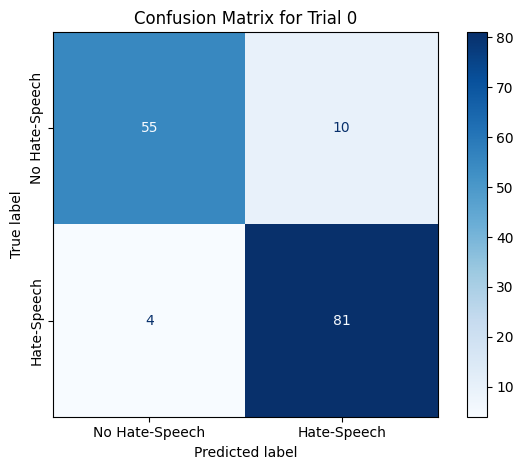

2025-01-04 23:30:09,734 - INFO - New best S score: 0.9331767905533288


S,█▁
accuracy,█▁
eval/S,▁▁▁▁▁▂▃▃▄▆▇▇▇▇██▇
eval/accuracy,▁▁▁▁▁▂▃▃▄▆▇▇█▇███
eval/f1,▁▁▁▁▁▁▂▂▃▆▇▇▇▇██▇
eval/f2,▁▁▁▁▁▂▂▃▃▆▆▆▇▇▇█▄
eval/loss,█████▇▆▆▅▄▃▃▂▂▁▁▃
eval/mcc,▁▁▁▁▂▂▃▄▄▆▇▇█▇███
eval/mcc_normalized,▁▁▁▁▂▂▃▄▄▆▇▇█▇███
eval/precision,▁▁▁▁▁▁▂▂▃▅▆▆▇▆▇▇█
eval/recall,██████▇█▇▆▅▄▅▇▅▇▁


[I 2025-01-04 23:30:11,046] Trial 0 finished with value: 0.9331767905533288 and parameters: {'num_train_epochs': 4, 'learning_rate': 5.629628861408828e-05, 'batch_size': 16, 'weight_decay': 0.08653175651469623}. Best is trial 0 with value: 0.9331767905533288.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F2,Mcc,Mcc Normalized,S
10,0.698900,0.682156,0.420000,0.388489,0.964286,0.553846,0.743802,0.111385,0.555692,0.649747
20,0.701500,0.675374,0.380000,0.375839,1.000000,0.546341,0.750670,0.063232,0.531616,0.641143
30,0.647800,0.675915,0.373333,0.373333,1.000000,0.543689,0.748663,0.000000,0.500000,0.624332
40,0.611300,0.692249,0.373333,0.373333,1.000000,0.543689,0.748663,0.000000,0.500000,0.624332
50,0.646500,0.692718,0.373333,0.373333,1.000000,0.543689,0.748663,0.000000,0.500000,0.624332
60,0.590600,0.672766,0.373333,0.373333,1.000000,0.543689,0.748663,0.000000,0.500000,0.624332
70,0.564000,0.638245,0.413333,0.385714,0.964286,0.551020,0.741758,0.095775,0.547887,0.644823
80,0.538900,0.607790,0.486667,0.411765,0.875000,0.560000,0.714286,0.155672,0.577836,0.646061
90,0.614700,0.584144,0.520000,0.431034,0.892857,0.581395,0.735294,0.220347,0.610174,0.672734
100,0.442700,0.557808,0.546667,0.447368,0.910714,0.600000,0.754438,0.272378,0.636189,0.695313


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already r

2025-01-04 23:30:23,526 - INFO - Trial 1 - Validation Metrics: {'accuracy': 0.8333333333333334, 'precision': 0.6962025316455697, 'recall': 0.9821428571428571, 'f1': 0.8148148148148148, 'f2': 0.9075907590759076, 'mcc': 0.704116149563978, 'mcc_normalized': 0.852058074781989, 'S': 0.8798244169289483}


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
2025-01-04 23:30:23,630 - INFO - Trial 1 - Test Metrics: {'accuracy': 0.8733333333333333, 'precision': 0.83, 'recall': 0.9764705882352941, 'f1': 0.8972972972972973, 'f2': 0.9431818181818182, 'mcc': 0.7515293607641007, 'mcc_normalized': 0.8757646803820504, 'S': 0.9094732492819343}


<Figure size 800x600 with 0 Axes>

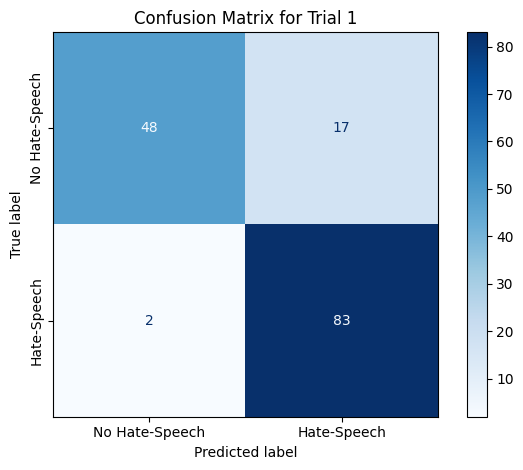

S,▁█
accuracy,▁█
eval/S,▂▁▁▁▁▁▂▂▂▃▄▅▆█▇▅█
eval/accuracy,▂▁▁▁▁▁▂▃▃▃▆▅██▇█▇
eval/f1,▁▁▁▁▁▁▁▁▂▂▄▅▇█▇▇█
eval/f2,▂▃▃▃▃▃▂▁▂▃▂▅▃██▁█
eval/loss,██████▇▇▆▆▅▄▃▁▃▅▁
eval/mcc,▂▂▁▁▁▁▂▃▃▄▆▅██▇██
eval/mcc_normalized,▂▂▁▁▁▁▂▃▃▄▆▅██▇██
eval/precision,▁▁▁▁▁▁▁▁▂▂▄▃▇▅▄█▅
eval/recall,▇█████▇▅▆▆▃▇▂▇█▁█


[I 2025-01-04 23:30:25,086] Trial 1 finished with value: 0.8798244169289483 and parameters: {'num_train_epochs': 2, 'learning_rate': 6.778440887269864e-05, 'batch_size': 8, 'weight_decay': 0.06401769698301464}. Best is trial 0 with value: 0.9331767905533288.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F2,Mcc,Mcc Normalized,S
10,0.793700,0.713051,0.620000,0.400000,0.035714,0.065574,0.043668,0.010238,0.505119,0.274393
20,0.749400,0.686689,0.526667,0.415730,0.660714,0.510345,0.591054,0.105876,0.552938,0.571996
30,0.666600,0.671289,0.373333,0.373333,1.000000,0.543689,0.748663,0.000000,0.500000,0.624332
40,0.630300,0.680068,0.373333,0.373333,1.000000,0.543689,0.748663,0.000000,0.500000,0.624332
50,0.595800,0.684084,0.373333,0.373333,1.000000,0.543689,0.748663,0.000000,0.500000,0.624332
60,0.582000,0.654254,0.373333,0.373333,1.000000,0.543689,0.748663,0.000000,0.500000,0.624332
70,0.506600,0.625592,0.380000,0.375839,1.000000,0.546341,0.750670,0.063232,0.531616,0.641143
80,0.510100,0.568428,0.493333,0.424242,1.000000,0.595745,0.786517,0.285023,0.642511,0.714514


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


2025-01-04 23:30:34,041 - INFO - Trial 2 - Validation Metrics: {'accuracy': 0.6266666666666667, 'precision': 0.5, 'recall': 0.9821428571428571, 'f1': 0.6626506024096386, 'f2': 0.8233532934131736, 'mcc': 0.43427217874043406, 'mcc_normalized': 0.717136089370217, 'S': 0.7702446913916954}


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
2025-01-04 23:30:34,144 - INFO - Trial 2 - Test Metrics: {'accuracy': 0.7333333333333333, 'precision': 0.6829268292682927, 'recall': 0.9882352941176471, 'f1': 0.8076923076923077, 'f2': 0.9071274298056156, 'mcc': 0.5007566409489618, 'mcc_normalized': 0.7503783204744809, 'S': 0.8287528751400483}


<Figure size 800x600 with 0 Axes>

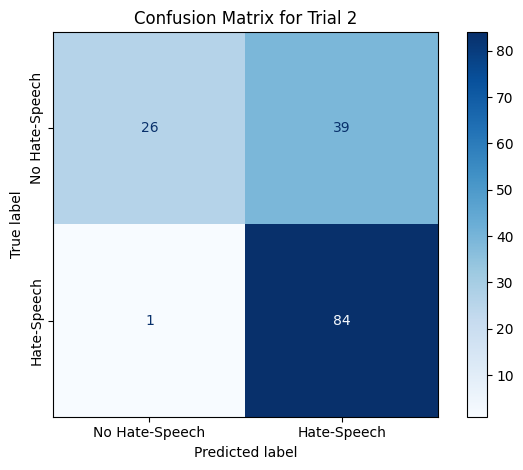

S,▁█
accuracy,▁█
eval/S,▁▆▇▇▇▇▇█
eval/accuracy,█▅▁▁▁▁▁▄
eval/f1,▁▇▇▇▇▇▇█
eval/f2,▁▆██████
eval/loss,█▇▆▆▇▅▄▁
eval/mcc,▁▄▁▁▁▁▃█
eval/mcc_normalized,▁▄▁▁▁▁▃█
eval/precision,▅▇▁▁▁▁▁█
eval/recall,▁▆██████


[I 2025-01-04 23:30:35,607] Trial 2 finished with value: 0.7702446913916954 and parameters: {'num_train_epochs': 4, 'learning_rate': 4.059287936794262e-05, 'batch_size': 32, 'weight_decay': 0.05271728763089815}. Best is trial 0 with value: 0.9331767905533288.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F2,Mcc,Mcc Normalized,S
10,0.734800,0.701344,0.373333,0.336207,0.696429,0.453488,0.573529,-0.141777,0.429111,0.501320
20,0.685400,0.689109,0.373333,0.373333,1.000000,0.543689,0.748663,0.000000,0.500000,0.624332
30,0.617000,0.699227,0.373333,0.373333,1.000000,0.543689,0.748663,0.000000,0.500000,0.624332
40,0.608300,0.707060,0.373333,0.373333,1.000000,0.543689,0.748663,0.000000,0.500000,0.624332
50,0.587000,0.674535,0.373333,0.373333,1.000000,0.543689,0.748663,0.000000,0.500000,0.624332
60,0.586700,0.636589,0.420000,0.390071,0.982143,0.558376,0.753425,0.136967,0.568483,0.660954
70,0.499500,0.617468,0.466667,0.411765,1.000000,0.583333,0.777778,0.247642,0.623821,0.700799
80,0.514000,0.571801,0.533333,0.440678,0.928571,0.597701,0.760234,0.267364,0.633682,0.696958


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


2025-01-04 23:30:44,665 - INFO - Trial 3 - Validation Metrics: {'accuracy': 0.64, 'precision': 0.5094339622641509, 'recall': 0.9642857142857143, 'f1': 0.6666666666666666, 'f2': 0.8181818181818182, 'mcc': 0.4367370590344263, 'mcc_normalized': 0.7183685295172131, 'S': 0.7682751738495157}


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
2025-01-04 23:30:44,776 - INFO - Trial 3 - Test Metrics: {'accuracy': 0.7333333333333333, 'precision': 0.6890756302521008, 'recall': 0.9647058823529412, 'f1': 0.803921568627451, 'f2': 0.8932461873638344, 'mcc': 0.4839839642827292, 'mcc_normalized': 0.7419919821413646, 'S': 0.8176190847525995}


<Figure size 800x600 with 0 Axes>

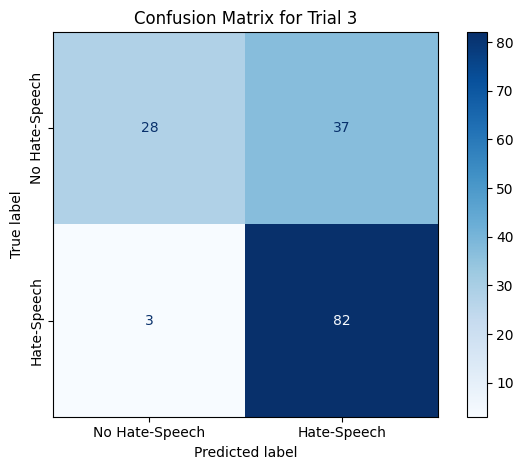

S,▁█
accuracy,▁█
eval/S,▁▅▅▅▅▇██
eval/accuracy,▁▁▁▁▁▃▅█
eval/f1,▁▅▅▅▅▆▇█
eval/f2,▁▇▇▇▇▇█▇
eval/loss,█▇██▆▄▃▁
eval/mcc,▁▃▃▃▃▆██
eval/mcc_normalized,▁▃▃▃▃▆██
eval/precision,▁▃▃▃▃▅▆█
eval/recall,▁██████▆


[I 2025-01-04 23:30:46,292] Trial 3 finished with value: 0.7682751738495157 and parameters: {'num_train_epochs': 4, 'learning_rate': 5.751670839914263e-05, 'batch_size': 32, 'weight_decay': 0.04957711452873461}. Best is trial 0 with value: 0.9331767905533288.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F2,Mcc,Mcc Normalized,S
10,0.728900,0.702987,0.380000,0.323810,0.607143,0.422360,0.516717,-0.156400,0.421800,0.469259
20,0.701400,0.692201,0.386667,0.378378,1.000000,0.549020,0.752688,0.089725,0.544863,0.648775
30,0.643300,0.691018,0.373333,0.373333,1.000000,0.543689,0.748663,0.000000,0.500000,0.624332
40,0.610500,0.700475,0.373333,0.373333,1.000000,0.543689,0.748663,0.000000,0.500000,0.624332
50,0.633000,0.691295,0.373333,0.373333,1.000000,0.543689,0.748663,0.000000,0.500000,0.624332
60,0.572100,0.671742,0.386667,0.378378,1.000000,0.549020,0.752688,0.089725,0.544863,0.648775
70,0.617700,0.646415,0.433333,0.394161,0.964286,0.559585,0.747922,0.139783,0.569891,0.658907
80,0.537400,0.634425,0.400000,0.383562,1.000000,0.554455,0.756757,0.127757,0.563878,0.660318


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already r

2025-01-04 23:30:54,267 - INFO - Trial 4 - Validation Metrics: {'accuracy': 0.4533333333333333, 'precision': 0.4057971014492754, 'recall': 1.0, 'f1': 0.5773195876288659, 'f2': 0.7734806629834254, 'mcc': 0.22760466886994402, 'mcc_normalized': 0.613802334434972, 'S': 0.6936414987091988}


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
2025-01-04 23:30:54,374 - INFO - Trial 4 - Test Metrics: {'accuracy': 0.62, 'precision': 0.5985915492957746, 'recall': 1.0, 'f1': 0.748898678414097, 'f2': 0.8817427385892116, 'mcc': 0.2714273495194843, 'mcc_normalized': 0.6357136747597422, 'S': 0.7587282066744769}


<Figure size 800x600 with 0 Axes>

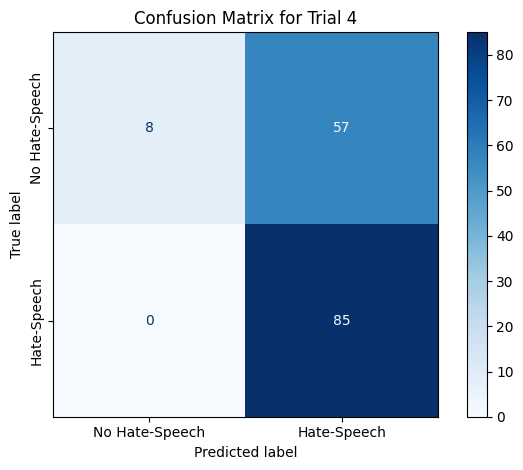

S,▁█
accuracy,▁█
eval/S,▁█▇▇▇███
eval/accuracy,▂▃▁▁▁▃█▄
eval/f1,▁▇▇▇▇▇██
eval/f2,▁███████
eval/loss,█▇▇█▇▅▂▁
eval/mcc,▁▇▅▅▅▇██
eval/mcc_normalized,▁▇▅▅▅▇██
eval/precision,▁▆▆▆▆▆█▇
eval/recall,▁█████▇█


[I 2025-01-04 23:30:55,844] Trial 4 finished with value: 0.6936414987091988 and parameters: {'num_train_epochs': 2, 'learning_rate': 5.1876727935610325e-05, 'batch_size': 16, 'weight_decay': 0.04648024994242984}. Best is trial 0 with value: 0.9331767905533288.
2025-01-04 23:30:56,804 - INFO - Trial results saved to: /content/drive/MyDrive/model/logged_model_metrics.xlsx
2025-01-04 23:30:56,806 - INFO - Best Hyperparameters: {'num_train_epochs': 4, 'learning_rate': 5.629628861408828e-05, 'batch_size': 16, 'weight_decay': 0.08653175651469623}
2025-01-04 23:30:56,810 - INFO - Best Trial Number: 0
2025-01-04 23:30:57,856 - INFO - Best model from Trial Number 0 saved to /content/drive/MyDrive/model/best_model_CNN_2025-01-04_23-30
2025-01-04 23:30:57,857 - INFO - wandb.finish() completed successfully.
2025-01-04 23:30:57,858 - INFO - Process finished and terminated


In [ ]:
if __name__ == "__main__":
  try:
      # Optuna Study. Uses MedianPruner as 'Early Stopping Method'. The pruning starts after the 15th trial and only allows pruning after the third epoch.
      study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_startup_trials=15, n_warmup_steps=3))

      logger.info(f"Sampler is {study.sampler.__class__.__name__}") # TPESampler is default in Optuna. uses by default 10 Trials for its startup

      study.optimize(objective, n_trials=50) # defines the total number of trials and calls objective function

      # Additional logging in Excel file
      excel_file_path = "/content/drive/MyDrive/model/logged_model_metrics.xlsx" # Check if the Excel file exists
      if os.path.exists(excel_file_path):
          # File exists, load and append new data
          existing_df = pd.read_excel(excel_file_path, index_col="Trial_Name")
          new_df = pd.DataFrame(all_results)
          new_df.set_index("Trial_Name", inplace=True)
          results_df = pd.concat([existing_df, new_df])  # Concatenate DataFrames
      else:
          # File doesn't exist, create new one
          results_df = pd.DataFrame(all_results)
          results_df.set_index("Trial_Name", inplace=True)

      # Save the DataFrame to the Excel file
      results_df.to_excel(excel_file_path)

      logger.info(f"Trial results saved to: {excel_file_path}")

      # Log the best hyperparameters
      best_params = study.best_params
      logger.info(f"Best Hyperparameters: {best_params}")
      #wandb.log(best_params)

      timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")

      # Save the best model and tokenizer
      if best_model_state_dict is not None:
          best_model_dir = f"/content/drive/MyDrive/model/best_model_CNN_{timestamp}"
          os.makedirs(best_model_dir, exist_ok=True)
          best_trial = study.best_trial
          logger.info(f"Best Trial Number: {best_trial.number}")

          # create distinct model file name
          model_filename = f"model_CNN_trial_{best_trial.number}_{timestamp}.bin"

          # model_filename = f"pytorch_model_trial_{best_trial.number}_{timestamp}.pth" # alternative file format

          # Save model
          torch.save(best_model_state_dict, os.path.join(best_model_dir, model_filename)) # this passes the mode.state_dict of the best model

          # Save tokenizer
          tokenizer.save_pretrained(best_model_dir)

          logger.info(f"Best model from Trial Number {best_trial.number} saved to {best_model_dir}")

          # wandb.finish()
          safe_wandb_finish(timeout=45) # function needs to be revised again

          logger.info("Process finished and terminated")

          # Allow threads to finish
          time.sleep(5)

          runtime.unassign()

      else:
          logger.error("No best model was found. Model could not be saved. Runtime will be terminated...")
          runtime.unassign()

  except Exception as e:
        # Logging and runtime termination
        logger.error(f"An error occurred during execution: {str(e)}", exc_info=True)
        runtime.unassign()
